<h1>The mother base</h1>

In this notebook we will show how to find the optimum points to build the drone distribution centers to support the Accident and Emergengy (AE) facilities of the NHS.<br>

First thing is obviously to import the packages we are going to need.

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Importing and setting seaborn.
import seaborn as sns
sns.set()
sns.set_context("talk", font_scale=1.2)

Then we will use pandas to open the csv file containing the data.

In [2]:
# Importing the data with NHS facilities.
aelocs_df = pd.read_csv('aelocsdf.csv', index_col=0)
aelocs_df['Latitude'] = aelocs_df['Latitude'].astype(float)
aelocs_df['Longitude'] = aelocs_df['Longitude'].astype(float)
aelocs_df.head()

,Name,Latitude,Longitude
0,St Mary's Hospital,49.913052,-6.309288
1,St. Mary's Hospital,50.710843,-1.301330
2,Newham General Hospital,51.522776,0.034717
3,The Royal London Hospital,51.519036,-0.059228
4,Whipps Cross University Hospital,51.578831,0.002638


There is a small catch though, the csv file made available was already pre processed to join the AE locations and their geographical coordinates. Both files containing the locations and a mapping of postcode to geographical coordinates are made available by the British government. <br>

Below there is an example on how to join the two dataframes.

In [3]:
# Importing the dataframe with the lat/lon -> postcode data.
#postcode_df = pd.read_csv("open_postcode_geo.csv", header=None, usecols=[0,7,8])
#postcode_df.columns = ['Postcode', 'Latitude','Longitude',]
#aelocs_df = aelocs_df.merge(postcode_df,how='left',on='Postcode')
#del postcode_df

Since we are working with geographical data it is convenient to have a map on the background for context. It is fairly straight forward to do so using the sample datasets that are included in the geopandas library.

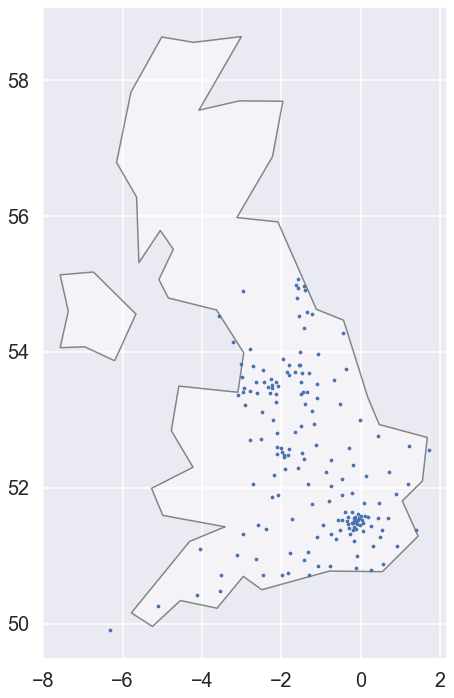

In [4]:
# Importing the sample map.
df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Creating the axes with map
ax = df[df.name == 'United Kingdom'].plot(figsize=(14, 12), 
                                          alpha=0.5, 
                                          edgecolor='k',
                                          color='white')

# Scattering the AE locations on the top of the map
plt.scatter(aelocs_df['Longitude'],aelocs_df['Latitude'],s=5)

Although it does a fair job to provide context this is a sample map with quite low resolution. Maps with higher resolution are generally available in open source libraries.<br>

Regardless of the resolution keep in mind that when working with maps data is always subject to deprojection effects (i.e., deformations in the map caused by trying to represent the Earth's spherical surface in cartesian coordinates).<br>

<h3>Where we actually solve the problem</h3>

Now that the data is ready we can actually proceed to solve the problem of finding the optimal places to build the drone centers. In this context clustering methods are just the tool we are looking for as they are build to divide the data into groups based on their distances from each other.<br>

Fortunately clustering methods are quite well developed and can be implemented with relative ease using [SciKit-Learn](https://scikit-learn.org/stable/modules/clustering.html). Below we will use the demonstrate how to use the clustering library to solve the problem.

In [5]:
from sklearn.cluster import KMeans

In [6]:
# Defining the KMeans function for 5 clusters.
kmeans = KMeans(n_clusters=5,init='k-means++' )

# Fitting the data
kmeans.fit(aelocs_df[['Latitude','Longitude']])

KMeans(n_clusters=5)

In [7]:
kmeans.cluster_centers_

array([[ 5.35156955e+01, -2.59762397e+00],
       [ 5.16226328e+01,  1.77722923e-02],
       [ 5.18161318e+01, -1.80865683e+00],
       [ 5.05570070e+01, -4.24998529e+00],
       [ 5.39161814e+01, -1.36096457e+00]])

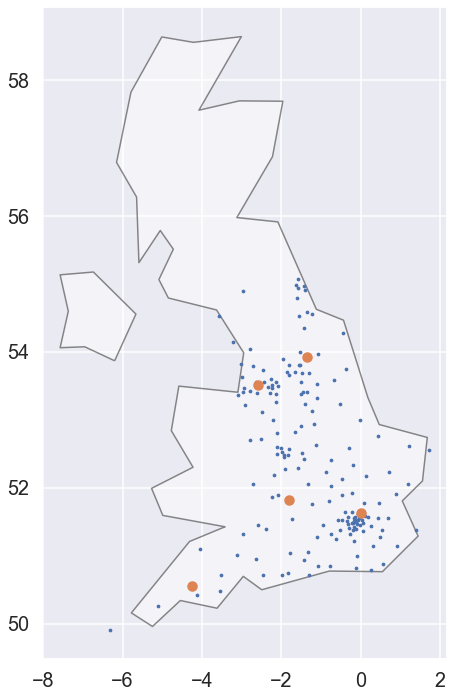

In [8]:
# Plotting the results
ax = df[df.name == 'United Kingdom'].plot(figsize=(14, 12), alpha=0.5, edgecolor='k',color='white')
plt.scatter(aelocs_df['Longitude'],aelocs_df['Latitude'],s=5)

plt.scatter(kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,0])

#for result in kmeans.cluster_centers_:
#    plt.scatter(result[1],result[0], color='black')
#    circle1 = plt.Circle((result[1],result[0]), 1.35, color='g', alpha=.25)
#    ax.add_patch(circle1)
#    circle2 = plt.Circle((result[1],result[0]), .36, color='yellow', alpha=.25)
#    ax.add_patch(circle2)

To add more context and represent the coverage area we can overlay the range that the drones that will be used for this study have.<br>

Two different models will be used one having a ranges of 120km and 25,2km.

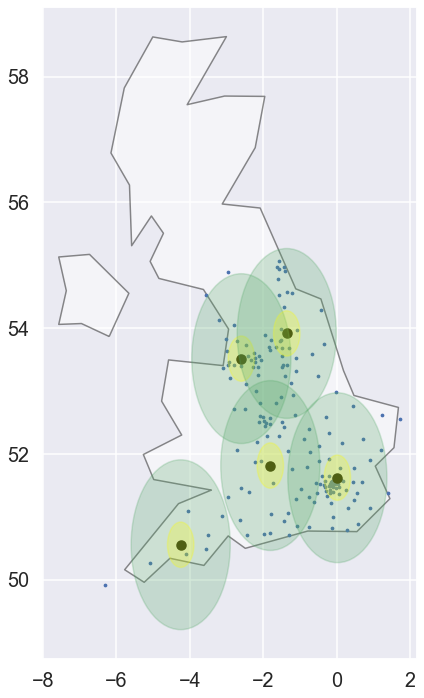

In [9]:
# Plotting the results
ax = df[df.name == 'United Kingdom'].plot(figsize=(14, 12), alpha=0.5, edgecolor='k',color='white')
plt.scatter(aelocs_df['Longitude'],aelocs_df['Latitude'],s=5)

for result in kmeans.cluster_centers_:
    plt.scatter(result[1],result[0], color='black')
    # Overlaying a circle that represents the range.
    circle1 = plt.Circle((result[1],result[0]), 1.35, color='g', alpha=.25)
    ax.add_patch(circle1)
    circle2 = plt.Circle((result[1],result[0]), .36, color='yellow', alpha=.25)
    ax.add_patch(circle2)

Now that we know how to find the optimum locations to build the drone facilities centers, we will loop the method to search for the best number of facilities that should be built.

C:\Users\andre\anaconda3\envs\general\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


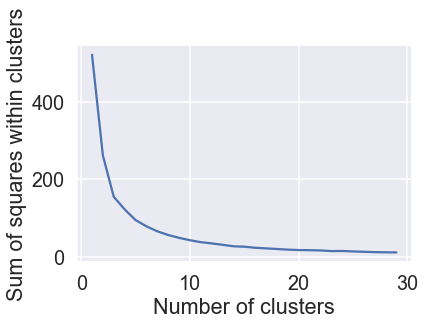

[521.5583019335455, 261.5142967395189, 154.85544608237964, 122.5390910705895, 94.88676538433282, 78.71344814864551, 65.8178716133203, 56.31137931431271, 48.923808798534374, 42.80503244876753, 37.753538202830086, 34.6093886908991, 30.97147935228316, 27.08665484822755, 26.04171586957701, 23.29398938517971, 21.709635169095172, 20.13721843865076, 18.45638352757232, 17.377030987283444, 17.066845857103058, 16.38799072334089, 14.728357106662568, 15.001287185682978, 13.853219523828175, 12.89391127103704, 12.01286009775906, 11.552232368252149, 11.268276176427145]


In [10]:
SSE_clusters=[]
centers = []
# This loop will fit the k-means algorithm
for i in range(1,30):
    
    kmeans = KMeans(n_clusters=i,init='k-means++' )
    kmeans.fit(aelocs_df[['Latitude','Longitude']])
    
    # Stores the within cluster sum of squares 
    SSE_clusters.append(kmeans.inertia_)
    centers.append(kmeans.cluster_centers_)

plt.plot(range(1,30),SSE_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squares within clusters')
plt.show()
print(SSE_clusters)

<h1>But there is a catch...</h1>
    
Using this method of calculation on data that represents locations in the Earth can have some unintended [consequences....](https://www.youtube.com/watch?v=1gHbwT_R9t0)